In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def loadData():
    with np.load("notMNIST.npz") as data:
        Data, Target = data["images"], data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:10000], Target[:10000]
        validData, validTarget = Data[10000:16000], Target[10000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget


In [4]:
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))

    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest


In [5]:
def shuffle(trainData, trainTarget):
    np.random.seed(421)
    randIndx = np.arange(len(trainData))
    target = trainTarget
    np.random.shuffle(randIndx)
    data, target = trainData[randIndx], target[randIndx]
    return data, target



In [30]:
def plot_print_accuracy(iterations, pred_train,pred_validation,pred_test) :
    fig, ax = plt.subplots()
    ax.plot(iterations, pred_train,label = 'Train')
    ax.plot(iterations, pred_test,label = 'Test')
    ax.plot(iterations, pred_validation, label = 'Validation')
    
    plt.legend(['Train','Test' ,'Validation'], loc='lower right')
    plt.show()
    
    return

In [15]:
def plot_print_loss(iterations, loss_train,loss_validation,loss_test) :
    fig, ax = plt.subplots()
    ax.plot(iterations, loss_train,label = 'Train')
    ax.plot(iterations, loss_test, label = 'Test')
    
    ax.plot(iterations, loss_validation, label = 'Validation')
    plt.legend(['Train', 'Test','Validation'], loc='upper right')

    #print("Test loss : "+str(loss_test))
    plt.show()
    return

In [8]:
training_epoch = 50 
learning_rate = 0.0001 
mini_batch_size = 32
resuf = 10000 / mini_batch_size
classes_out = 10
total_iterations =int(training_epoch * 10000 / mini_batch_size)


In [22]:
class stocastic_gradient_descent() :
    def buildGraph(self) :
        self.x = tf.placeholder("float", [None, 28,28,1])
        self.y = tf.placeholder("float", [None, classes_out])
        initializer = tf.contrib.layers.xavier_initializer()
        W1 = tf.Variable(initializer([4,4,1,32]))
        b1 = tf.Variable( initializer([32]))

        W2 = tf.Variable( initializer([28*28*32,32]))
        b2 = tf.Variable( initializer([32]))
 
        W3 = tf.Variable( initializer([32,classes_out]))
        b3 = tf.Variable( initializer([classes_out]))
        
        self.lmbd = tf.placeholder("float", shape=())
        self.prb = tf.placeholder("float", shape=())
        self.is_training = tf.placeholder("bool", shape=())
        
        conv1 = tf.nn.conv2d(self.x, W1, strides=[1, 1, 1, 1], padding='SAME')
        conv1 = tf.nn.bias_add(conv1, b1)
        conv1 = tf.nn.relu(conv1)

        batch_mean, batch_var = tf.nn.moments(conv1,[0])
        Batch_normalization = tf.nn.batch_normalization(conv1,batch_mean,batch_var,None,None,1e-5)

        max_pool = tf.nn.max_pool(Batch_normalization, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1],
                                  padding='SAME')

        fc1 = tf.reshape(max_pool, [-1, W2.get_shape()[0]])
        fc1 = tf.add(tf.matmul(fc1, W2), b2)
        fc1 = tf.nn.relu(fc1)
        
        drpout = tf.layers.dropout(fc1,rate=self.prb,training=self.is_training)

        fc2 = tf.reshape(drpout, [-1, W3.get_shape()[0]])
        fc2 = tf.add(tf.matmul(fc2, W3), b3)

        pred = tf.nn.softmax(fc2)

        loss = (tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=self.y))
        reg_loss1 = tf.nn.l2_loss(W1)
        reg_loss2 = tf.nn.l2_loss(W2)
        reg_loss3 = tf.nn.l2_loss(W3)

        total_loss = tf.reduce_mean(loss + self.lmbd*(reg_loss1+reg_loss2+reg_loss3))

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(total_loss)

        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(self.y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        
        return self.x,self.y,self.lmbd,self.prb,self.is_training,total_loss,optimizer,accuracy

In [24]:
def modelTraining(lmb=0,prb=0) :
    trainData, validData, testData, trainTarget, validTarget, testTarget= loadData()
    train_y, valid_y, test_y = convertOneHot( trainTarget, validTarget, testTarget)
    train_x = trainData
    test_X = testData
    validation_X = validData
    
    np.random.seed(421)
    train_x = train_x.reshape(-1, 28, 28, 1)
    validation_x = validation_X.reshape(-1, 28, 28, 1)
    test_x = test_X.reshape(-1, 28, 28, 1)
    lossfunc = stocastic_gradient_descent()
    
    x,y,lmbd,prob,is_training,total_loss,optimizer,accuracy = lossfunc.buildGraph()
    
    init = tf.global_variables_initializer()
    train_loss = []
    test_loss = []
    validation_loss = []
    train_accuracy = []
    validation_accuracy = []
    test_accuracy= []
    total_iter=[]
    
    with tf.Session() as sess:
        sess.run(init) 

    
        for iter in range(total_iterations):
            if iter% int(resuf) == 0 :
                train_x ,  train_y = shuffle(trainData=train_x,trainTarget=train_y)

            total_iter.append(iter)
            image_up = train_x[(iter*mini_batch_size)%10000:((iter*mini_batch_size)%10000)+mini_batch_size]
            target_up = train_y[(iter*mini_batch_size)%10000:((iter*mini_batch_size)%10000)+mini_batch_size]
            opt = sess.run(optimizer, feed_dict={x: image_up,y: target_up,is_training:True,lmbd:lmb,prob:prb})

            loss, acc = sess.run([total_loss, accuracy], feed_dict={x: image_up,y: target_up,is_training:False,lmbd:lmb,prob:prb})
            train_loss.append(loss)
            train_accuracy.append(acc)


            valid_cost,valid_accu = sess.run([total_loss, accuracy], feed_dict={x: validation_x,y : valid_y,is_training:False,lmbd:lmb,prob:prb})
            validation_loss.append(valid_cost)
            validation_accuracy.append(valid_accu)


            loss_test, acc_test = sess.run([total_loss, accuracy], feed_dict={x: test_x,y: test_y,is_training:False,lmbd:lmb,prob:prb})
            test_loss.append(loss_test)
            test_accuracy.append(acc_test)

            print("Iter " + str(iter) + ", Train Loss:" + "{:.3f}".format(loss) + ", Train Acc:" + "{:.3f}".format(acc) + ", Valid Loss:" + "{:.3f}".format(valid_cost) + ", Valid Acc:" + "{:.3f}".format(valid_accu) + ", Test Loss:" + "{:.3f}".format(loss_test) + ", Test Acc:" + "{:.3f}".format(acc_test))

    return total_iter,train_loss,train_accuracy, validation_loss,validation_accuracy, test_loss,test_accuracy

In [ ]:

##### 2.2
total_iter,train_loss1,train_accuracy1, validation_loss1,validation_accuracy1, test_loss1,test_accuracy1 = modelTraining(0,0)

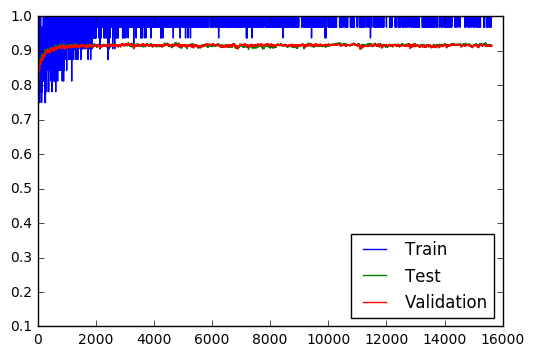

In [60]:
plot_print_accuracy(total_iter,train_accuracy,validation_accuracy,test_accuracy)

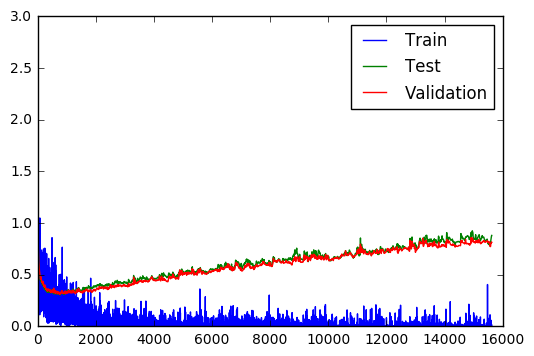

In [61]:
plot_print_loss(total_iter,train_loss,validation_loss,test_loss)

In [ ]:

##### 2.3.1 lambda = 0.01 
total_iter,train_loss2,train_accuracy2, validation_loss2,validation_accuracy2, test_loss2,test_accuracy2 = modelTraining(0.01,0)

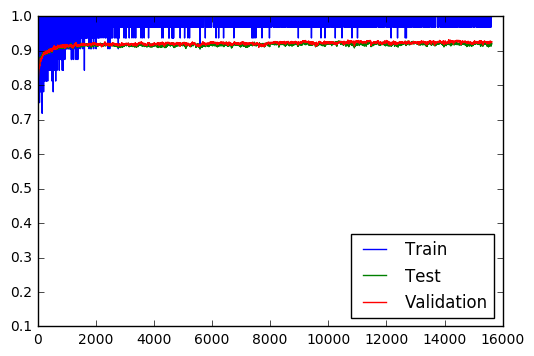

In [31]:
plot_print_accuracy(total_iter,train_accuracy2,validation_accuracy2,test_accuracy2)

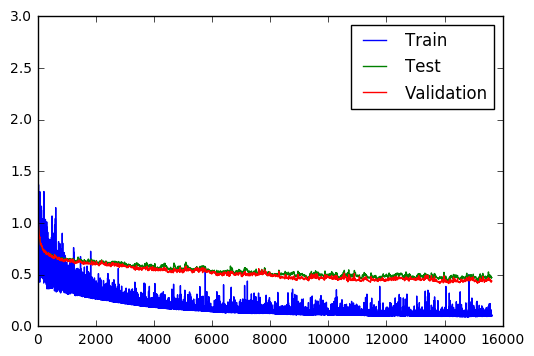

In [17]:
plot_print_loss(total_iter,train_loss2,validation_loss2,test_loss2)

In [62]:
print(train_loss[len(test_loss2) -1])
print(validation_loss[len(test_loss2) -1])
print(test_loss[len(test_loss2) -1])
print(train_accuracy[len(test_loss2) -1])
print(validation_accuracy[len(test_loss2) -1])
print(test_accuracy[len(test_loss2) -1])


0.00015021031
0.8140684
0.8808553
1.0
0.9155
0.9137298


In [ ]:

##### 2.3.1 lambda = 0.1 
total_iter,train_loss3,train_accuracy3, validation_loss3,validation_accuracy3, test_loss3,test_accuracy3 = modelTraining(0.1,0)

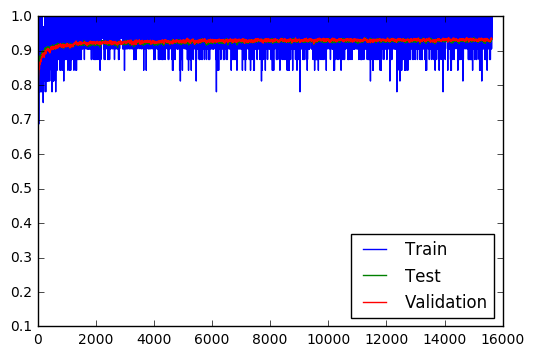

In [32]:
plot_print_accuracy(total_iter,train_accuracy3,validation_accuracy3,test_accuracy3)

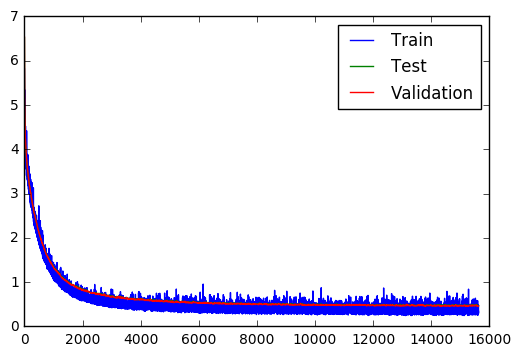

In [20]:
plot_print_loss(total_iter,train_loss3,validation_loss3,test_loss3)

In [ ]:

##### 2.3.1 lambda = 0.5
total_iter,train_loss4,train_accuracy4, validation_loss4,validation_accuracy4, test_loss4,test_accuracy4 = modelTraining(0.5,0)

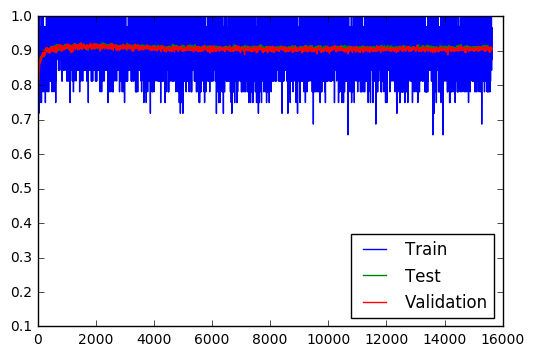

In [33]:
plot_print_accuracy(total_iter,train_accuracy4,validation_accuracy4,test_accuracy4)

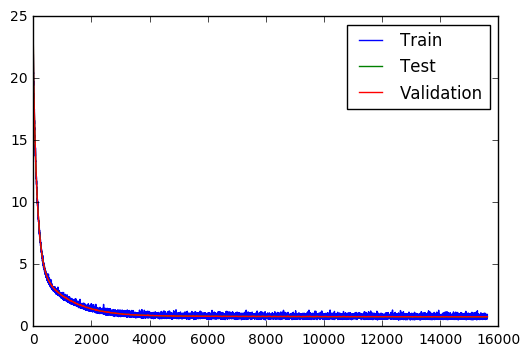

In [23]:
plot_print_loss(total_iter,train_loss4,validation_loss4,test_loss4)

In [ ]:

##### 2.3.1 prb = 0.9
total_iter,train_loss5,train_accuracy5, validation_loss5,validation_accuracy5, test_loss5,test_accuracy5 = modelTraining(0,0.9)

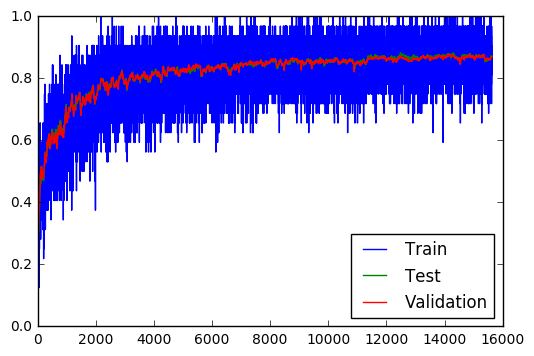

In [36]:
plot_print_accuracy(total_iter,train_accuracy5,validation_accuracy5,test_accuracy5)

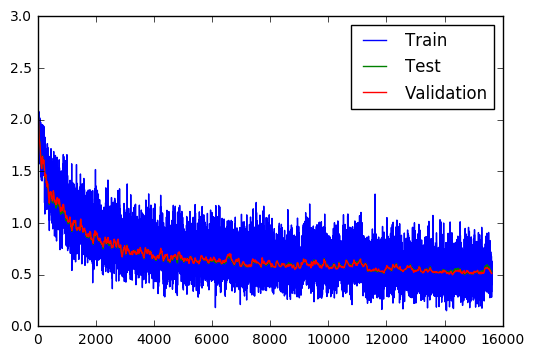

In [37]:
plot_print_loss(total_iter,train_loss5,validation_loss5,test_loss5)

In [49]:

##### 2.3.1 prb = 0.75
total_iter,train_loss6,train_accuracy6, validation_loss6,validation_accuracy6, test_loss6,test_accuracy6 = modelTraining(0,0.75)

NameError: name 'modelTraining' is not defined

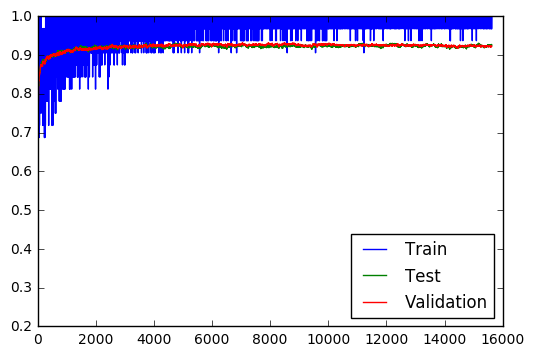

In [50]:
plot_print_accuracy(total_iter,train_accuracy6,validation_accuracy6,test_accuracy6)

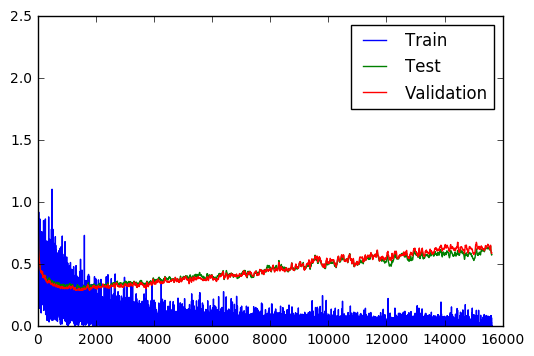

In [51]:
plot_print_loss(total_iter,train_loss6,validation_loss6,test_loss6)

In [ ]:

##### 2.3.1 prb = 0.50
total_iter,train_loss7,train_accuracy7, validation_loss7,validation_accuracy7, test_loss7,test_accuracy7 = modelTraining(0,0.50)

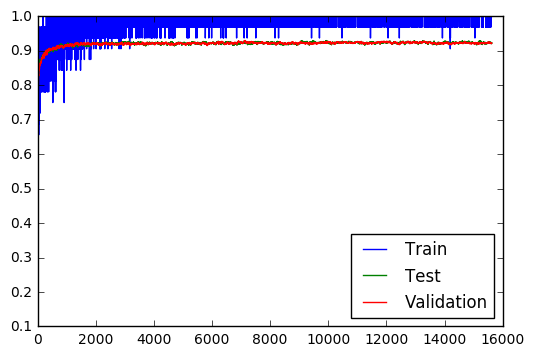

In [58]:
plot_print_accuracy(total_iter,train_accuracy7,validation_accuracy7,test_accuracy7)

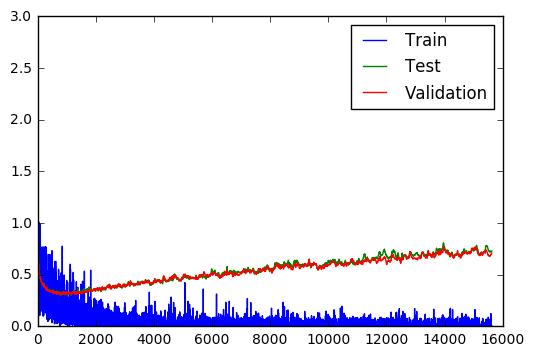

In [57]:
plot_print_loss(total_iter,train_loss7,validation_loss7,test_loss7)